In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import semopy as sem
import scipy.stats as sts
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
from statistics import stdev, mean

# 1. Data Pre-processing

The datasets we were given, shown below, were previously cleaned and delivered to us afterwards. Therefore, not a lot of data pre-processing was required, besides the following actions:

## 1.1 Merging and combining datasets

Merging and combining the datasets provided according to patients ids ('f.eid').

In [2]:
# Loading all the data
data_all = pd.read_csv('all_causality_data.csv')
data_new = pd.read_csv('ukbb_cardio_merged_unclean.csv', error_bad_lines=False)
data_bp = pd.read_csv('ukbb_bp_merged_unclean.csv')
radiomics_groups = pd.read_csv('radiomics.groups.csv', header = None)
data_all.shape, data_new.shape, data_bp.shape, radiomics_groups.shape

b'Skipping line 281516: expected 50 fields, saw 86\n'
C:\Users\Alejandro\Downloads\ANACONDA\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14,15,17,18,20,21,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((2141, 1396), (502418, 50), (502536, 14), (630, 1))

In [3]:
# Merging data_new and data_bp = data2
ids = data_new.iloc[:,1]
data_new_ids = data_bp[data_bp['f.eid'].isin(ids)]
data_new_ids = data_new_ids.sort_values(by = 'f.eid')
data2 = pd.merge(data_new, data_new_ids, on='f.eid',  how='left')
data2.shape

(502418, 63)

In [4]:
# Merging data2 and data_all = data
ids2 = data_all.iloc[:,1]
data_new_ids2 = data2[data2['f.eid'].isin(ids2)]
data_new_ids2 = data_new_ids2.sort_values(by = 'f.eid')
data = pd.merge(data_all, data_new_ids2.rename(columns={'f.eid':'heart_f_eid'}), on='heart_f_eid',  how='left')
data = data.drop(['Unnamed: 0', 'heart_f_eid'], axis=1)
data.shape

(2141, 1456)

In [5]:
# Changing heart radiomics columns names
radiomics_groups = radiomics_groups[0].values.tolist()
heart_df = data.filter(regex='heart')
data = data[data.columns.drop(list(data.filter(regex='heart')))]
heart_df.columns = radiomics_groups
data = pd.concat([data, heart_df], axis=1)
data.shape

(2141, 1456)

## 1.2 Selecting data instance collection

Data was collected at three instances: 'baseline', 'calibration' and 'imaging'. We selected the instance with the least number of missing values, which is 'baseline', and drop the other two.

In [6]:
baseline_df = data.filter(regex='baseline')
calibration_df = data.filter(regex='calibration')
imaging_df = data.filter(regex=':imaging')
baseline_df.shape, calibration_df.shape, imaging_df.shape

((2141, 20), (2141, 20), (2141, 20))

In [7]:
baseline_df.isna().sum().sum(), calibration_df.isna().sum().sum(), imaging_df.isna().sum().sum()

(17796, 33513, 17859)

In [8]:
data = data[data.columns.drop(list(data.filter(regex='calibration')))]
data = data[data.columns.drop(list(data.filter(regex=':imaging')))]

## 1.3 Remove missing values

Due to our large sample size, removing entire rows with missing values was considered to be the best approach to have a complete final dataset. Our resulting final dataset has 2065 patients and 1416 variables.

In [9]:
data = data[data['bio:systolic_blood_pressure,_automated_reading:0:baseline'].notna()]
data = data[data['bio:age_stopped_smoking:0:baseline'] != 'Do not know']
data.shape

(2065, 1416)

# 2. Feature extraction

Several new features were extracted from our initial VRFs variables: smoking pack years and WHR.

## 2.1 Smoking pack years

Pack years was calculated as the number of cigarettes per day smoked by each patient, then divided by 20, and lastly multiplied by the number of years patients reported having smoked for.

However, in order to extract this feature, first we had to substitute "Do not know" responses. Cigarette smoking variables presented plenty of these type of categorical values. Therefore, replacing them with 0 was considered to be the best approach. Also, some other categorical variables were encoded using integer encoding, that consist in referencing each possible categorical value with an integer, such as "Less than one a day" subtituted by 1.

In [10]:
data['bio:age_started_smoking_in_former_smokers:0:baseline'] = data['bio:age_started_smoking_in_former_smokers:0:baseline'].replace('Do not know', np.nan)
data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'] = data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'].replace('Do not know', np.nan)
data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'] = data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'].replace('Less than one a day', 1)

In [11]:
data['bio:age_started_smoking_in_former_smokers:0:baseline'] = data['bio:age_started_smoking_in_former_smokers:0:baseline'].fillna(0)
data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'] = data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'].fillna(0)
data['bio:age_stopped_smoking:0:baseline'] = data['bio:age_stopped_smoking:0:baseline'].fillna(0)

In [12]:
data['bio:age_started_smoking_in_former_smokers:0:baseline'] = data['bio:age_started_smoking_in_former_smokers:0:baseline'].astype(str).astype(int)
data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'] = data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'].astype(str).astype(int)
data['bio:age_stopped_smoking:0:baseline'] = data['bio:age_stopped_smoking:0:baseline'].astype(str).astype(int)

In [13]:
data['pack_years'] = ((data['bio:number_of_cigarettes_previously_smoked_daily:0:baseline'] / 20)*
                      (data['bio:age_stopped_smoking:0:baseline'] - data['bio:age_started_smoking_in_former_smokers:0:baseline']))

In [14]:
data['pack_years'].describe()

count    2065.000000
mean        4.177772
std         9.995071
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       111.000000
Name: pack_years, dtype: float64

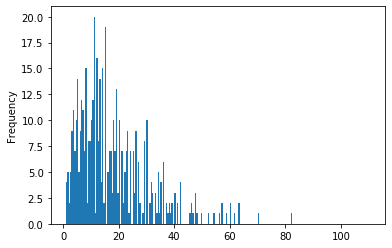

In [15]:
bin_values = np.arange(start=1, stop=111, step=0.5)
data['pack_years'].plot(kind='hist', bins=bin_values)

## 2.2 Waist-Hip Ratio (WHR)

Waist and hip measurements were conducted to provide WHR.

In [16]:
data['WHR'] = data['bio:waist_circumference:0:baseline'] / data['bio:hip_circumference:0:baseline']

In [17]:
data['WHR'].describe()

count    2065.000000
mean        0.860974
std         0.087590
min         0.607843
25%         0.790476
50%         0.860000
75%         0.924528
max         1.160000
Name: WHR, dtype: float64

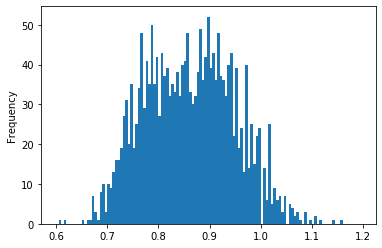

In [18]:
bin_values = np.arange(start=0.6, stop=1.2, step=0.005)
data['WHR'].plot(kind='hist', bins=bin_values)

# 3. Data Normalization

In general, learning algorithms benefit from standardization of the data set, and for example some algorithms will improve cardiovascular predictions if all numerical features are zero centered and have a variance of the same magnitude order [1]. For this reason, some of our VRFs were normalized using Z-Score normalization due to the nature and distribution of the variables.  These variables were SBP, DBP, Pack years, BMI, and WHR.

In the following plot we can see the distribution of these variables before normalization:

<center><img src="Figures/before normalization 4.png"></center>

In [19]:
data['SBP_norm'] = ((data['bio:systolic_blood_pressure,_automated_reading:0:baseline'] - 
                                         mean(data['bio:systolic_blood_pressure,_automated_reading:0:baseline'])) 
                                        / stdev(data['bio:systolic_blood_pressure,_automated_reading:0:baseline']))

data['DBP_norm'] = ((data['bio:diastolic_blood_pressure,_automated_reading:0:baseline'] - 
                                         mean(data['bio:diastolic_blood_pressure,_automated_reading:0:baseline'])) 
                                        / stdev(data['bio:diastolic_blood_pressure,_automated_reading:0:baseline']))

data['pack_years_norm'] = ((data['pack_years'] - mean(data['pack_years'])) / stdev(data['pack_years']))

data['BMI_norm'] = ((data['bio:body_mass_index_(bmi):0:baseline'] - mean(data['bio:body_mass_index_(bmi):0:baseline'])) 
                          / stdev(data['bio:body_mass_index_(bmi):0:baseline']))

data['WHR_norm'] = ((data['WHR'] - mean(data['WHR'])) / stdev(data['WHR']))

In the following plot we can see the distribution of these variables after normalization:

<center><img src="Figures/zscore normalization.png"></center>

As we can see, all these variables are centered at 0 and have a standard deviation of 1, handling this way all the outliers that were present in the data. Also, it is noticeable that blood pressure related variables (SBP and DBP) have a normal distribution.

# 4. Dimensionality reduction

First of all we derived an aggregate measure of vascular risk to quantify overall load of VRFs for each patient. Secondly, we also derived a latent factor of general vascular risk (gVRF) to capture the tendency for VRFs to co-occur. 

## 4.1 Aggregate measure of vascular risk

An aggregate measure of vascular risk for each individual was derived to quantify overall load of VRFs for each patient, counting instances of a self-reported diagnosis of hypertension, diabetes, or hypercholesterolaemia, having ever smoked, having a BMI > 25, and having a high WHR (>0.85 for females and >0.90 for males), following prior work in an older cohort [2].

In [20]:
agg_score = data["cardio_cov_hypertens"] + data["cardio_cov_diabetes"] + data["cardio_cov_highchol"] + data["cardio_cov_smoker"]
data["agg_score"] = agg_score

In [21]:
data['binary_bmi'] = data['bio:body_mass_index_(bmi):0:baseline'].apply(lambda x: 1 if x > 25 else 0)
data["agg_score"] = data["agg_score"] + data['binary_bmi']

In [22]:
data['WHR'] = (data['bio:waist_circumference:0:baseline'] / data['bio:hip_circumference:0:baseline'])

binary_WHR = []

for i in data["cardio_cov_sex"].values:
    if i == 0: #female
        binary_WHR.append(data['WHR'].apply(lambda x: 1 if x > 0.85 else 0))
    if i == 1: #male
        binary_WHR.append(data['WHR'].apply(lambda x: 1 if x > 0.90 else 0))

In [23]:
data['binary_WHR'] = binary_WHR[0]
data["agg_score"] = data["agg_score"] + data['binary_WHR']

In [24]:
data["agg_score"].value_counts()

1    606
2    555
0    523
3    273
4     91
5     17
Name: agg_score, dtype: int64

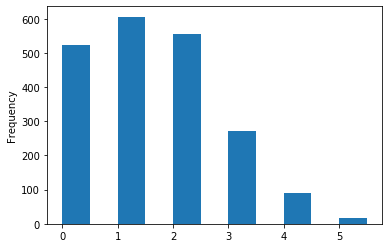

In [25]:
bin_values = np.arange(start=0, stop=6, step=0.5)
data["agg_score"].plot(kind='hist', bins=bin_values)

In this plot we can see the distribution of our derived aggregate measure of vascular risk. This measure quantifies the overall load of VRFs for each patient, and as we can see the distribution is very unbalanced, since for example there are only 17 patients with an overall load of VRFs of 5, while there are 606 patients with an overall load of VRFs of 1.

## 4.2 Latent factor of general vascular risk (gVRF)

We also derived a latent factor of general vascular risk (gVRF) following prior work in an older cohort [3], using confirmatory factor analysis in structural equation modelling. This latent measure captures, and depends upon, the tendency for VRFs to co occur. Using the Factor Analyzer package for python, gVRF was derived from smoking pack years, DBP, SBP, BMI, WHR, self-reported hypertension, diabetes and hypercholesterolaemia.

In [26]:
gVRF_data = data.filter(['pack_years_norm', 
                         'SBP_norm',
                         'DBP_norm',
                         'BMI_norm','WHR_norm',
                         'cardio_cov_hypertens', 'cardio_cov_diabetes', 'cardio_cov_highchol'], axis=1)

In [27]:
gVRF_data.head()

,pack_years_norm,SBP_norm,DBP_norm,BMI_norm,WHR_norm,cardio_cov_hypertens,cardio_cov_diabetes,cardio_cov_highchol
0,-0.417983,-0.224747,-0.233023,-0.249758,0.356015,0,0,0
1,-0.417983,0.471542,-1.277238,-0.280856,0.494141,0,0,0
2,-0.417983,1.810559,1.855407,-0.614887,-0.696126,0,0,1
3,-0.417983,-1.081719,-1.656953,-0.286582,-0.060549,0,0,1
4,2.283348,-0.331869,-0.992453,-0.273563,0.549348,0,0,0


In this plot we can see a correlation plot of all the variables being used to extract this gVRF, in which a strong correlation between SBP and DBP is noticeable, as well as for BMI and WHR. This result makes sense since these pairs of variables measure similar VRFs.

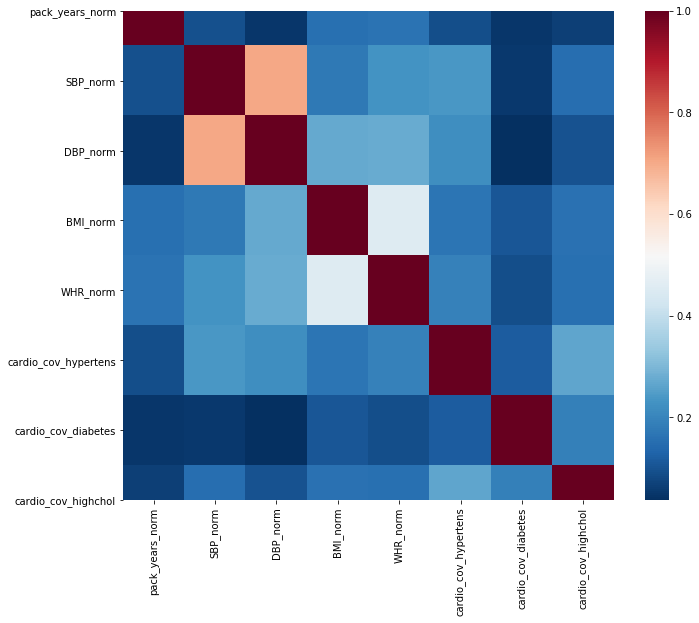

In [28]:
cardio_corr = gVRF_data.corr()
plt.figure(figsize=(11,9))
sns.heatmap(cardio_corr, cmap=plt.cm.RdBu_r)
plt.show()

In [29]:
cardio_corr

,pack_years_norm,SBP_norm,DBP_norm,BMI_norm,WHR_norm,cardio_cov_hypertens,cardio_cov_diabetes,cardio_cov_highchol
pack_years_norm,1.000000,0.095554,0.051120,0.153932,0.164172,0.091503,0.051235,0.067252
SBP_norm,0.095554,1.000000,0.705272,0.175163,0.232288,0.236678,0.054996,0.151550
DBP_norm,0.051120,0.705272,1.000000,0.273815,0.276447,0.220325,0.037273,0.098563
BMI_norm,0.153932,0.175163,0.273815,1.000000,0.455522,0.165563,0.105392,0.159549
WHR_norm,0.164172,0.232288,0.276447,0.455522,1.000000,0.193767,0.089974,0.156897
cardio_cov_hypertens,0.091503,0.236678,0.220325,0.165563,0.193767,1.000000,0.118813,0.264241
cardio_cov_diabetes,0.051235,0.054996,0.037273,0.105392,0.089974,0.118813,1.000000,0.189009
cardio_cov_highchol,0.067252,0.151550,0.098563,0.159549,0.156897,0.264241,0.189009,1.000000


### 4.2.1 Exploratory Factor Analysis (EFA)

Factor analysis (FA) is a modeling technique that explains the covariance in data. In FA, the observed variables are linear combinations of the unobserved variables. In addition, underlying factors are labelable and interpretable. We conducted both Exploratory and Confirmatory Factor Analysis (EFA and CFA) using the Factor Analyzer package for python [4].

To measure the suitability of FA, two different tests were run: KMO Test and Bartlett’s Test.

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. It estimates the proportion of variance among all the observed variables. Lower
proportion is more suitable for factor analysis. KMO values range between 0 and 1, and if the value is less than 0.6 is considered inadequate.

In [30]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model = calculate_kmo(gVRF_data)
kmo_model

0.6418346201741154

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, FA should not be employed. On the contrary, if the p-value is close to 0 the test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [31]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(gVRF_data)
chi_square_value, p_value

(2719.7108599126655, 0.0)

KMO test result and the Bartlett’s testof sphericity are considered adecuate and statisticallysignificant.  Therefore, securing the suitability of the data being used to extract this latent factor for FA.

In [32]:
#Create factor analysis object and perform factor analysis
fa_cardio = FactorAnalyzer(1, rotation = None)
fa_cardio.fit(gVRF_data)

FactorAnalyzer(n_factors=1, rotation=None, rotation_kwargs={})

Eigenvalues represent variance explained each factor from the total variance. It is also known as characteristic roots.

In [33]:
# # Check Eigenvalues
ev, v = fa_cardio.get_eigenvalues()
ev

array([2.3900766 , 1.23075346, 1.08043631, 0.90243685, 0.85755959,
       0.71350639, 0.54463786, 0.28059295])

Kaiser criterion is an analytical approach, which is based on the more significant proportion of variance explained by factor will be selected. The eigenvalue is a good criterion for determining the number of factors. Generally, an eigenvalue greater than 1 will be considered as selection criteria for the feature. The graphical approach is based on the visual representation of factors' eigenvalues also called scree plot. This scree plot helps us to determine the number of factors where the curve makes an elbow.

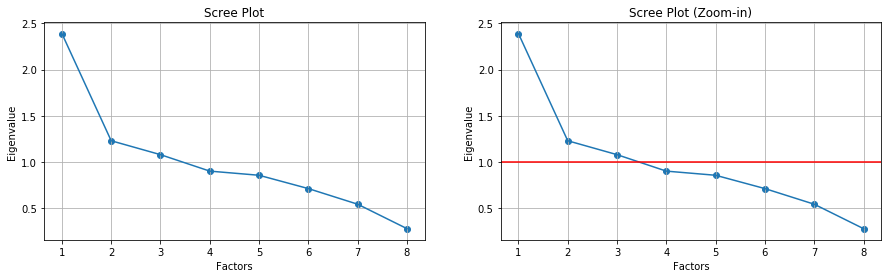

In [34]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(121)
plt.scatter(range(1,gVRF_data.shape[1]+1),ev)
plt.plot(range(1,gVRF_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
fig.add_subplot(122)
plt.scatter(range(1,gVRF_data.shape[1]+1),ev)
plt.plot(range(1,gVRF_data.shape[1]+1),ev)
plt.axhline(1,color='r')
plt.title('Scree Plot (Zoom-in)')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

The factor loading is a matrix which shows the relationship of each variable to the underlying factor. It also shows the correlation coefficient for the observed variables and the factor, and the variance explained by the observed variables.

In [35]:
cardio_loadings = pd.DataFrame(fa_cardio.loadings_, columns= ['Loadings'], index=gVRF_data.columns)
cardio_loadings.sort_values(by=['Loadings'], ascending=True )

,Loadings
cardio_cov_diabetes,0.155718
pack_years_norm,0.186169
cardio_cov_highchol,0.283791
cardio_cov_hypertens,0.380753
BMI_norm,0.457422
WHR_norm,0.490945
SBP_norm,0.686705
DBP_norm,0.723294


Commonalities are the sum of the squared loadings for each variable. It represents the common variance. It ranges from 0-1 and value close to 1 represents more variance.

In [36]:
cardio_commu = pd.DataFrame(fa_cardio.get_communalities(), columns= ['Communality'], index= gVRF_data.columns)
cardio_commu.sort_values(by=['Communality'], ascending=False )

,Communality
DBP_norm,0.523154
SBP_norm,0.471564
WHR_norm,0.241027
BMI_norm,0.209235
cardio_cov_hypertens,0.144973
cardio_cov_highchol,0.080537
pack_years_norm,0.034659
cardio_cov_diabetes,0.024248


### 4.2.2 Confirmatory Factor Analysis (CFA)

A ConfirmatoryFactorAnalyzer class, which fits a confirmatory factor analysis model using maximum likelihood.

In [37]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecification)

In [38]:
model_specification = ModelSpecification(cardio_loadings.values, 1, 8, cardio_corr.values)

In [39]:
fa_cardio2 = ConfirmatoryFactorAnalyzer(model_specification, disp = False)
fa_cardio2.fit(gVRF_data)

C:\Users\Alejandro\Downloads\ANACONDA\lib\site-packages\factor_analyzer\confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


ConfirmatoryFactorAnalyzer(disp=False, n_obs=2065,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x00000200818ECF60>)

In [40]:
cardio_loadings = pd.DataFrame(fa_cardio2.loadings_, columns= ['Loadings'], index= gVRF_data.columns)
cardio_loadings.sort_values(by=['Loadings'], ascending=False )

,Loadings
DBP_norm,0.723294
SBP_norm,0.686705
WHR_norm,0.490945
BMI_norm,0.457422
cardio_cov_hypertens,0.380753
cardio_cov_highchol,0.283791
pack_years_norm,0.186169
cardio_cov_diabetes,0.155718


Loadings are inconsistent (range 0.1557–0.7232), with the factor more strongly loaded towards DBP and SBP.

In [41]:
g_VRF = fa_cardio2.transform(gVRF_data)
g_VRF.shape

(2065, 1)

In [42]:
data['g_VRF'] = g_VRF
min(data['g_VRF']), max(data['g_VRF'])

(-2.845107575484941, 3.7170123628733265)

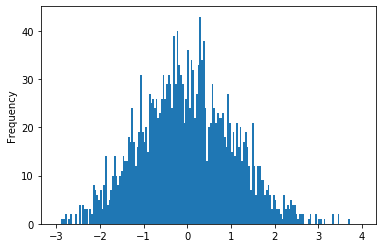

In [43]:
bin_values = np.arange(start=-3, stop=4, step=0.04)
data['g_VRF'].plot(kind='hist', bins=bin_values)

Here we can see the distribution of our derived gVRF, which is as well centered at 0 and has a normal distribution, similar to the variables to which this latent factor was derived with.

In [44]:
data.to_csv(r'casuality_data_final_factor_analyzer.csv', index = False)

# 5. References

[1]: [Martin-Isla, Carlos et al. (2020)](https://www.frontiersin.org/articles/10.3389/fcvm.2020.00001/full). Image-Based Cardiac Diagnosis With Machine Learning: A Review

[2]: [Cox, Simon R et al. (Mar. 2019a)](https://academic.oup.com/eurheartj/article/40/28/2290/5371095). Associations between vascular risk factors and brain MRI indices in UK Biobank

[3]: [Wardlaw, JM. et al. (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4001185/). Vascular risk factors, large-artery atheroma, and brain white matter hyperintensities

[4]: [Navlani, A. (2019)](https://www.datacamp.com/community/tutorials/introduction-factor-analysis). Introduction to Factor Analysis in Python